In [1]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from matplotlib import pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import linear_model

In [13]:
df = pd.read_csv('total_data_mining.csv')

In [14]:
df.head()

,Name,central_freq,contact_freq,central_freq_amp,peak_count,peak_mean,peak_SD,peak_matters_SD,peak_matters_Int,dixi,target
0,marina1_0,1.269531,1.269531,0.001318,87,0.000498,0.000290,2.826011,0.001298,5.633683e-16,False
1,marina1_1,1.269531,1.269531,0.001327,85,0.000501,0.000293,2.823573,0.001307,5.587141e-01,True
2,marina1_2,1.269531,1.269531,0.001328,85,0.000501,0.000292,2.833311,0.001308,5.589952e-01,True
3,marina1_3,1.269531,1.269531,0.001328,87,0.000497,0.000291,2.858880,0.001308,5.607146e-01,True
4,marina1_4,1.269531,1.269531,0.001353,85,0.000498,0.000305,2.804777,0.001332,3.440126e-16,False


In [15]:
df = df.drop('contact_freq', 1)
df.head()

,Name,central_freq,central_freq_amp,peak_count,peak_mean,peak_SD,peak_matters_SD,peak_matters_Int,dixi,target
0,marina1_0,1.269531,0.001318,87,0.000498,0.000290,2.826011,0.001298,5.633683e-16,False
1,marina1_1,1.269531,0.001327,85,0.000501,0.000293,2.823573,0.001307,5.587141e-01,True
2,marina1_2,1.269531,0.001328,85,0.000501,0.000292,2.833311,0.001308,5.589952e-01,True
3,marina1_3,1.269531,0.001328,87,0.000497,0.000291,2.858880,0.001308,5.607146e-01,True
4,marina1_4,1.269531,0.001353,85,0.000498,0.000305,2.804777,0.001332,3.440126e-16,False


In [16]:
df.head()

,Name,central_freq,central_freq_amp,peak_count,peak_mean,peak_SD,peak_matters_SD,peak_matters_Int,dixi,target
0,marina1_0,1.269531,0.001318,87,0.000498,0.000290,2.826011,0.001298,5.633683e-16,False
1,marina1_1,1.269531,0.001327,85,0.000501,0.000293,2.823573,0.001307,5.587141e-01,True
2,marina1_2,1.269531,0.001328,85,0.000501,0.000292,2.833311,0.001308,5.589952e-01,True
3,marina1_3,1.269531,0.001328,87,0.000497,0.000291,2.858880,0.001308,5.607146e-01,True
4,marina1_4,1.269531,0.001353,85,0.000498,0.000305,2.804777,0.001332,3.440126e-16,False


In [17]:
df['target'].value_counts()
nulls = df[df['target']==0].count()
nulls = nulls['Name']
ones = df[df['target']==1].count()
ones = ones['Name']

lenDiff = abs(nulls-ones)
halfLength = int(ones/2)
print(halfLength)

3149


In [18]:
df_null = df[df['target']==0].iloc[lenDiff:]
df_ed = df[df['target']==1]
df_train = pd.concat([df_null.head(halfLength), df_ed.head(halfLength)], ignore_index = True)
df_ver = pd.concat([df_null.tail(halfLength), df_ed.tail(halfLength)], ignore_index = True)

df_train.sample(frac=1).reset_index(drop=True)
df_ver.sample(frac=1).reset_index(drop=True)

,Name,central_freq,central_freq_amp,peak_count,peak_mean,peak_SD,peak_matters_SD,peak_matters_Int,dixi,target
0,Eremin_2_105,1.171875,0.000769,81,0.000167,0.000146,4.114312,0.000740,2.572963e-01,False
1,semchuk3_580,1.269531,0.000725,83,0.000390,0.000136,2.458529,0.000716,1.856353e-01,True
2,Eremin_2_683,0.585938,0.004145,86,0.000843,0.002132,1.549337,0.003775,1.879799e-01,False
3,Eremin_2_602,0.683594,0.008191,80,0.001262,0.001863,3.719770,0.007040,5.315427e-01,False
4,satanenko_2_183,1.171875,0.000422,89,0.000084,0.000220,1.532999,0.000419,3.922634e-16,True
5,Norkin_2_328,0.585938,0.000248,92,0.000054,0.000058,3.369643,0.000247,3.924395e-02,True
6,semcha_3_470,1.367188,0.000779,90,0.000237,0.000152,3.561211,0.000773,1.273098e-15,True
7,Berestenkova_2_382,1.171875,0.000256,76,0.000063,0.000059,3.274144,0.000255,9.665315e-03,True
8,semcha_2_160,0.683594,0.000537,75,0.000171,0.000086,4.277526,0.000534,1.945511e-01,True
9,Berestenkova_2_351,1.074219,0.000401,81,0.000066,0.000075,4.442812,0.000398,3.103445e-01,True


In [19]:
features = ['central_freq','central_freq_amp', 'peak_count','peak_mean','peak_SD','peak_matters_SD']
df_train[features].values

array([[  6.83593750e-01,   8.38900968e-04,   8.60000000e+01,
          3.29642404e-04,   1.62334911e-04,   3.13708592e+00],
       [  6.83593750e-01,   8.63151375e-04,   8.80000000e+01,
          3.26880638e-04,   1.63117353e-04,   3.28763756e+00],
       [  6.83593750e-01,   8.92948175e-04,   9.20000000e+01,
          3.23700481e-04,   1.64212808e-04,   3.46652433e+00],
       ..., 
       [  1.17187500e+00,   3.83962894e-04,   6.00000000e+01,
          8.50240369e-05,   7.25781475e-05,   4.11885488e+00],
       [  5.85937500e-01,   6.75100543e-04,   6.30000000e+01,
          1.08575356e-04,   1.26817792e-04,   4.46723742e+00],
       [  5.85937500e-01,   6.60395186e-04,   7.10000000e+01,
          1.25167509e-04,   1.45391011e-04,   3.68129827e+00]])

[ 0.50438995  0.          0.          0.16257189  0.          0.33303816]
[ 0.37156375  0.          0.          0.11976016  0.2633403   0.24533579]
[ 0.28406502  0.13797829  0.          0.18003026  0.21036421  0.18756221]
[ 0.21719986  0.20522721  0.02887714  0.23448438  0.17705091  0.13716051]
[ 0.21578179  0.19431666  0.03414103  0.24743324  0.18646716  0.12186012]
[ 0.18376146  0.18444958  0.04433737  0.2849067   0.18633828  0.11620661]
[ 0.1718686   0.17199853  0.04414786  0.29376904  0.18814233  0.13007363]
[ 0.16591896  0.16051387  0.06930707  0.26906646  0.18446377  0.15072988]
[ 0.1552839   0.18355089  0.07516232  0.25427452  0.16927128  0.16245709]
[ 0.13962056  0.18274581  0.08046627  0.25690519  0.18213249  0.15812967]
[ 0.1236419   0.19436776  0.08035581  0.2557707   0.18181262  0.16405121]
[ 0.12366938  0.18831155  0.08301873  0.2419687   0.17764013  0.18539151]
[ 0.1084439   0.18252394  0.08969377  0.25246547  0.17556853  0.1913044 ]
[ 0.11073327  0.17670053  0.09397726  

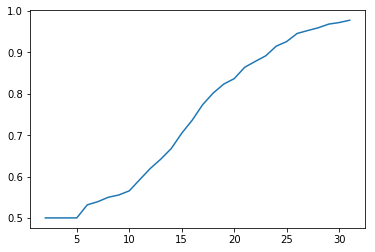

In [20]:
df_train = df
scores = []
deps = []

for i in range(2,32):    
    age_sal_tree = DecisionTreeClassifier(criterion='entropy', max_depth=i, max_features = len(features), random_state=1)
    age_sal_tree.fit(df_train[features].values, df_train['target'].values)
    scoreRes = age_sal_tree.score(df_ver[features].values, df_ver['target'].values)
    print(age_sal_tree.feature_importances_)
    scores.append(scoreRes)
    deps.append(i)
plt.plot(deps, scores)
plt.show()



export_graphviz(age_sal_tree, out_file='tree.dot', precision=5)


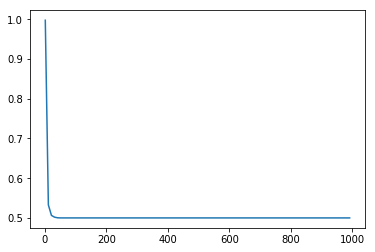

In [21]:
neis = []
scores = []
for i in range(1,1000, 10):
    nei = KNeighborsClassifier(n_neighbors=i)
    nei.fit(df_train[features].values, df_train['target'].values)
    scoreRes = nei.score(df_ver[features].values, df_ver['target'].values)
    neis.append(i)
    scores.append(scoreRes)
plt.plot(neis, scores)
plt.show()

[ 0.39406936  0.10606779  0.060872    0.18650422  0.12312069  0.12936594]
[ 0.39406936  0.10606779  0.060872    0.18650422  0.12312069  0.12936594]
[ 0.39406936  0.10606779  0.060872    0.18650422  0.12312069  0.12936594]
[ 0.39406936  0.10606779  0.060872    0.18650422  0.12312069  0.12936594]
[ 0.39406936  0.10606779  0.060872    0.18650422  0.12312069  0.12936594]
[ 0.39406936  0.10606779  0.060872    0.18650422  0.12312069  0.12936594]
[ 0.39406936  0.10606779  0.060872    0.18650422  0.12312069  0.12936594]
[ 0.39406936  0.10606779  0.060872    0.18650422  0.12312069  0.12936594]
[ 0.39406936  0.10606779  0.060872    0.18650422  0.12312069  0.12936594]
[ 0.39406936  0.10606779  0.060872    0.18650422  0.12312069  0.12936594]
[ 0.39406936  0.10606779  0.060872    0.18650422  0.12312069  0.12936594]
[ 0.39406936  0.10606779  0.060872    0.18650422  0.12312069  0.12936594]
[ 0.39406936  0.10606779  0.060872    0.18650422  0.12312069  0.12936594]
[ 0.39406936  0.10606779  0.060872    

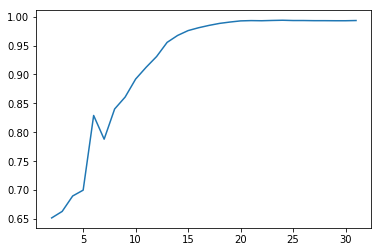

In [11]:
scores = []
deps = []
for i in range(2,32):    
    fore = RandomForestClassifier( max_depth=i, max_features = len(features), random_state=0)
    fore.fit(df_train[features].values, df_train['target'].values)
    scoreRes = fore.score(df_ver[features].values, df_ver['target'].values)
    print(age_sal_tree.feature_importances_)
    scores.append(scoreRes)
    deps.append(i)
plt.plot(deps, scores)
plt.show()

l1
log


/home/ivan7chuk/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


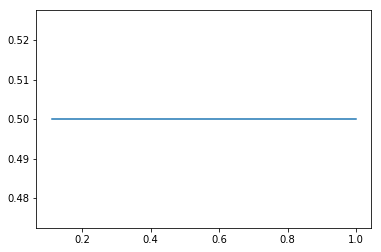

hinge


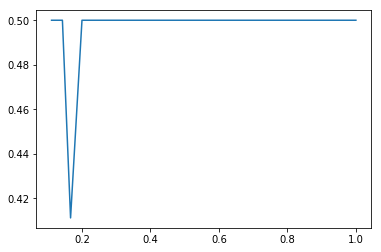

modified_huber


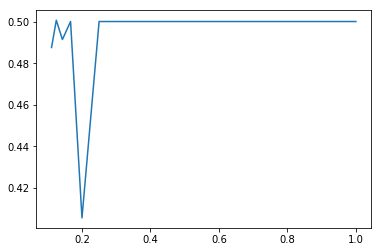

squared_hinge


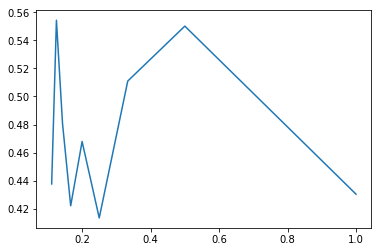

perceptron


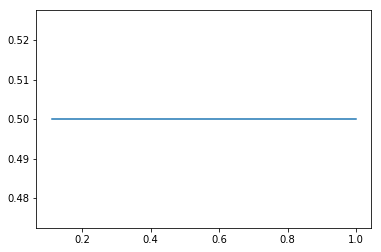

l2
log


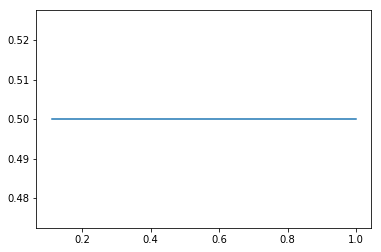

hinge


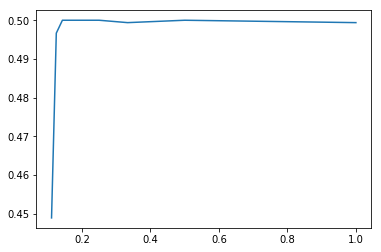

modified_huber


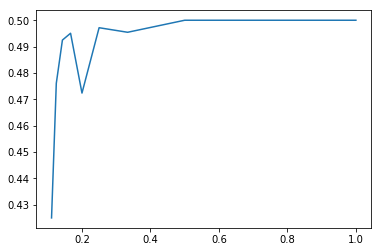

squared_hinge


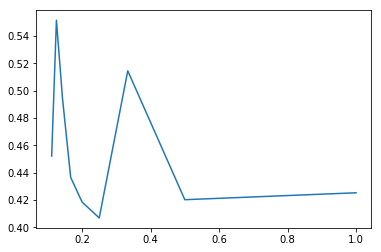

perceptron


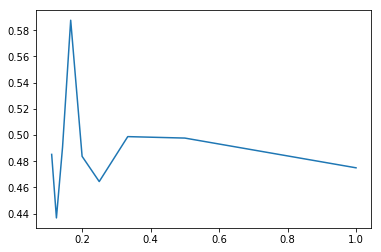

elasticnet
log


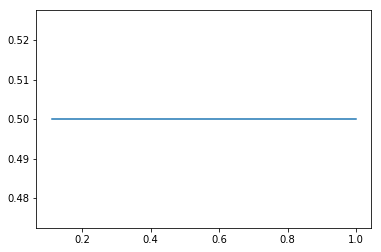

hinge


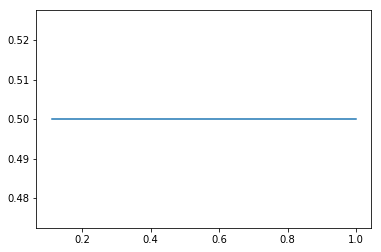

modified_huber


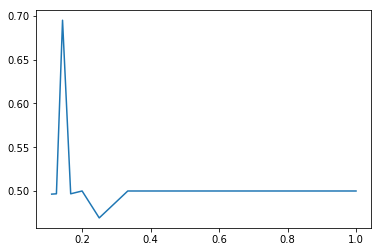

squared_hinge


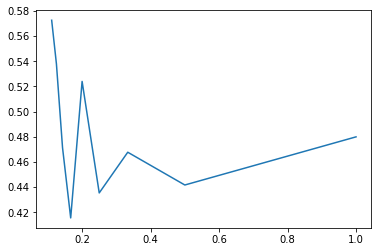

perceptron


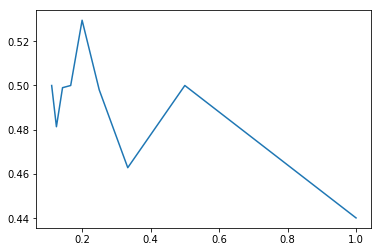

In [12]:
# ‘perceptron’, or a regression loss: ‘squared_loss’, ‘huber’, ‘epsilon_insensitive’, or ‘squared_epsilon_insensitive’.

lin_clf = linear_model.SGDClassifier()
penalties = ['l1','l2','elasticnet']
reguls = ['log', 'hinge', 'modified_huber', 'squared_hinge', 'perceptron']
for peny in penalties:
    print(peny)
    lin_clf.penalty = peny
    for reg in reguls:
        lin_clf.loss = reg
        print(reg)
        scores = []
        alphas = []
        for i in range(1, 10, 1):
            a = 1/i
            lin_clf.alpha = a
            lin_clf.fit(df_train[features].values, df_train['target'].values)
            scoreRes = lin_clf.score(df_ver[features].values, df_ver['target'].values)
            scores.append(scoreRes)
            alphas.append(a)
        plt.figure()
        plt.plot(alphas, scores)
        plt.show()
    

In [47]:
1/1000

0.001